In [128]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from get_json_data import load_data
import pandas as pd
import numpy as np
import math

In [143]:
#print('Loading training data')
data_name = "movie_score.json"
#data_name = "small_data_set/movie_score_train.json"
x, y = load_data(data_name)

배경음 love theme의 감동적인 선율과 영사기에서 나오는 달콤한 키스 장면들을 보며 토토의 회상에 젖은듯한 애잔한 표정 지금도 잊을수가 없다 


In [144]:
print(x[0])
print(y[0])

[  7  20   0  25  60  11  37  55  99 175 178 185 168  99 183 171 168 176
 168  11  38  99   0  19  55   3  27  60  12  23  40  11  39  43  99   9
  23  43  11  36  47   0  28  99  11  25  60   9  19   0  39  11  24   9
  23  99   2  19  11  27   2  37  43  99   3  19  47  15  27  55  18  19
  43  99  15  39   9  37  99  12  19  60   6  25  43   3  37  47  11  37
  47  99   7  27   6  25  99  16  27  16  27  11  38  99  18  30   9  19
  60  11  24  99  12  23  61  11  37  43   3  37  58  18  19  43  99  11
  20  12  19  43  18  19  43  99  17  31  12  23  60  99  12  39   0  37
  55   3  27  99  11  39  61  11  37  47   9  32   0  19  99  11  23  57
   3  19  99   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
9


In [145]:
print(set(y))
y = to_categorical(y)
print(y[0])

{0, 3, 4, 5, 6, 7, 8, 9}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [146]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=30)

In [147]:
sequence_length = 200 # x.shape[1] 
character_size = 251 # 251
embedding_dim = 256
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

In [148]:
epochs = 5
batch_size = 30
MODEL_WEIGHTS_FILE = 'rating_weights.h5'

In [149]:
# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=character_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=10, activation='softmax')(dropout)

Creating Model...


In [150]:
# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0000001)

callbacks = [learning_rate_reduction,
             EarlyStopping('val_loss', patience=2),
             ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')]

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print("Traning Model...")
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=(X_val, y_val))  # starts training

Traning Model...
Train on 1176 samples, validate on 490 samples
Epoch 1/5
1176/1176 [==============================] - 40s 34ms/step - loss: 0.2361 - acc: 0.9102 - val_loss: 0.1374 - val_acc: 0.9651

Epoch 00001: val_acc improved from -inf to 0.96510, saving model to rating_weights.h5
Epoch 2/5
1176/1176 [==============================] - 38s 33ms/step - loss: 0.1178 - acc: 0.9686 - val_loss: 0.1089 - val_acc: 0.9704

Epoch 00002: val_acc improved from 0.96510 to 0.97041, saving model to rating_weights.h5
Epoch 3/5
1176/1176 [==============================] - 39s 33ms/step - loss: 0.1082 - acc: 0.9703 - val_loss: 0.1044 - val_acc: 0.9710

Epoch 00003: val_acc improved from 0.97041 to 0.97102, saving model to rating_weights.h5
Epoch 4/5
1176/1176 [==============================] - 38s 32ms/step - loss: 0.1036 - acc: 0.9702 - val_loss: 0.1019 - val_acc: 0.9714

Epoch 00004: val_acc improved from 0.97102 to 0.97143, saving model to rating_weights.h5
Epoch 5/5
1176/1176 [==================

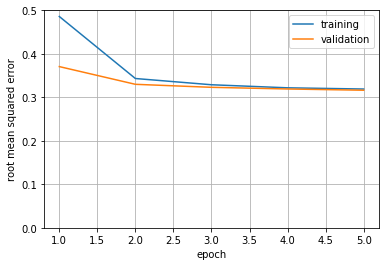

In [151]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = loss.loc[:,:].plot(x='epoch', grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([0.0,0.5]);

In [153]:
model.load_weights(MODEL_WEIGHTS_FILE)
print(set(y_test.argmax(axis=-1)))

{0, 3, 4, 5, 6, 7, 8, 9}


In [154]:
pred = model.predict(X_test).argmax(axis=1)

In [155]:
import sklearn
acc = sklearn.metrics.accuracy_score(y_test.argmax(axis=-1), pred)
acc

0.8418367346938775